In [82]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
# if possible we want to use the GPU for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [79]:
# flag for using google colab
colab_on = False
base_path = ""

In [80]:
# if we are using google colab we need to mount the drive
# and set the base path to the root of the drive
if colab_on:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/My Drive'

In [83]:
# load the data into tensors, target should be an integer
X = torch.tensor(np.load(os.path.join(base_path,'x_digits.npy')), dtype=torch.float32)
y = torch.tensor(np.load(os.path.join(base_path,'y_digits.npy')), dtype=torch.int64)


In [ ]:
X.shape, y.shape

(torch.Size([35631, 129, 71]), torch.Size([35631]))

In [ ]:
# zip the data and target together
zip_data = list(zip(X, y))

In [ ]:
# because the data is ordered (all examples of 0, then all examples of 1, etc.), we need to shuffle it, so our batches contain all classes
# we shuffle the pairs of observations and targets and then split the data into training, validation and test sets (64%, 16%, 20%)
subsets = torch.utils.data.random_split(zip_data, [0.64, 0.16, 0.2])

In [ ]:
batch_size = 64

In [ ]:
# create dataloaders for the training, validation and test set
# in training we want to shuffle the data each epoch, not to overfit to the order of the data
train_dataloader = DataLoader(subsets[0], batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(subsets[1], batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(subsets[2], batch_size=batch_size, shuffle=False)



In [ ]:
# we define our fully connected neural network
# we use batch normalization to stabilize training
# we also use it before the first layer to normalize the input data
# becaues the spectogram is 2D, we flatten it to a 1D tensor
# we use ReLU as activation function
# we use kaiming (He) initialization for the weights in linear layers, because we use ReLU
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.sequent = nn.Sequential(
            nn.BatchNorm1d(129*71), # kinda scaling
            nn.Linear(129*71, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10)
        )

        self.sequent.apply(self.__init_weights)

    def forward(self, x):
        x = self.flatten(x)
        x = self.sequent(x)
        return x

    def __init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)

In [ ]:
n_train = len(subsets[0].indices)
n_val = len(subsets[1].indices)
n_test = len(subsets[2].indices)

In [ ]:

def train(model, optimizer, scheduler = None, n_epochs = 30, early_stop_patience = -1):

    early_stop = 0
    min_val_loss = float('inf')

    for i in tqdm(range( n_epochs )):

        # we put the model in training mode (important for batch normalization)
        model.train()
        acc = 0
        total_loss = 0
        # we do forward and backward pass for each batch until we have seen all training data
        # we calculate the accuracy and loss for the training data
        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = F.cross_entropy(y_pred, y_batch)
            total_loss += loss
            acc += (torch.argmax(y_pred, dim=1) == y_batch).sum().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # because we were getting loss and accuracy per batch, we need to average it
        acc /= n_train
        total_loss /= len(train_dataloader)

        model.eval()
        val_loss = 0
        val_acc = 0
        # for validation we don't need to calculate gradients
        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                val_loss += F.cross_entropy(y_pred, y_batch).item()
                # we calculate the accuracy for the validation data
                # we check the number of cases where the class with highest predicted probability is the same as the target class
                # .item() extracts the value from the tensor
                val_acc += (torch.argmax(y_pred, dim=1) == y_batch).sum().item()

        val_loss /= len(val_dataloader)

        print(f"Epoch {i+1} - Accuracy: {acc:.4f} - Loss: {total_loss:.4f} - Val Loss: {val_loss:.4f}, Val accuracy: {val_acc/n_val:.4f}")

        # we implement early stopping, if the validation loss doesn't improve for 10 epochs, we stop training
        if early_stop_patience != -1:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                early_stop = 0
            else:
                early_stop += 1
                if early_stop == early_stop_patience:
                    break

        # we reduce the learning rate if the validation loss doesn't improve for 5 epochs
        if scheduler is not None:
            scheduler.step(val_loss)


In [ ]:
fcn_hyperparams = {
    'n_epochs': 30,
    'lr': 0.001,
    'scheduler_patience': 4,
    'scheduler_factor': 0.5,
    'early_stop_patience': 6,
    'weight_decay': 0.1
}

In [ ]:
# if possible transfer the model to the GPU
fcn = FCNet()
fcn = fcn.to(device)

# we use the AdamW optimizer and reduce the learning rate on plateau after 3 epochs without improvement
optimizer = torch.optim.AdamW(fcn.parameters(), lr=fcn_hyperparams['lr'], weight_decay=fcn_hyperparams['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=fcn_hyperparams['scheduler_patience'], factor=fcn_hyperparams['scheduler_factor'])

In [ ]:
train(fcn, optimizer, scheduler, fcn_hyperparams['n_epochs'], fcn_hyperparams['early_stop_patience'])

  3%|▎         | 1/30 [00:03<01:42,  3.52s/it]

Epoch 1 - Accuracy: 0.3543 - Loss: 1.8614 - Val Loss: 1.2719, Val accuracy: 0.5694


  7%|▋         | 2/30 [00:07<01:46,  3.80s/it]

Epoch 2 - Accuracy: 0.5492 - Loss: 1.2798 - Val Loss: 0.9456, Val accuracy: 0.6953


 10%|█         | 3/30 [00:11<01:38,  3.66s/it]

Epoch 3 - Accuracy: 0.6355 - Loss: 1.0601 - Val Loss: 0.8181, Val accuracy: 0.7402


 13%|█▎        | 4/30 [00:14<01:34,  3.62s/it]

Epoch 4 - Accuracy: 0.6792 - Loss: 0.9377 - Val Loss: 0.7445, Val accuracy: 0.7592


 17%|█▋        | 5/30 [00:18<01:30,  3.60s/it]

Epoch 5 - Accuracy: 0.7056 - Loss: 0.8572 - Val Loss: 0.6547, Val accuracy: 0.7869


 20%|██        | 6/30 [00:21<01:26,  3.60s/it]

Epoch 6 - Accuracy: 0.7311 - Loss: 0.7889 - Val Loss: 0.6493, Val accuracy: 0.7893


 23%|██▎       | 7/30 [00:25<01:22,  3.57s/it]

Epoch 7 - Accuracy: 0.7515 - Loss: 0.7316 - Val Loss: 0.6061, Val accuracy: 0.8018


 27%|██▋       | 8/30 [00:28<01:18,  3.56s/it]

Epoch 8 - Accuracy: 0.7610 - Loss: 0.7016 - Val Loss: 0.5685, Val accuracy: 0.8169


 30%|███       | 9/30 [00:32<01:14,  3.54s/it]

Epoch 9 - Accuracy: 0.7769 - Loss: 0.6635 - Val Loss: 0.5671, Val accuracy: 0.8141


 33%|███▎      | 10/30 [00:35<01:11,  3.58s/it]

Epoch 10 - Accuracy: 0.7810 - Loss: 0.6370 - Val Loss: 0.5391, Val accuracy: 0.8279


 37%|███▋      | 11/30 [00:39<01:10,  3.69s/it]

Epoch 11 - Accuracy: 0.7944 - Loss: 0.6143 - Val Loss: 0.5258, Val accuracy: 0.8265


 40%|████      | 12/30 [00:43<01:07,  3.73s/it]

Epoch 12 - Accuracy: 0.8017 - Loss: 0.5911 - Val Loss: 0.5079, Val accuracy: 0.8372


 43%|████▎     | 13/30 [00:48<01:07,  3.97s/it]

Epoch 13 - Accuracy: 0.8066 - Loss: 0.5702 - Val Loss: 0.5114, Val accuracy: 0.8323


 47%|████▋     | 14/30 [00:52<01:03,  3.97s/it]

Epoch 14 - Accuracy: 0.8119 - Loss: 0.5577 - Val Loss: 0.5294, Val accuracy: 0.8246


 50%|█████     | 15/30 [00:56<00:59,  3.95s/it]

Epoch 15 - Accuracy: 0.8135 - Loss: 0.5483 - Val Loss: 0.4988, Val accuracy: 0.8399


 53%|█████▎    | 16/30 [00:59<00:54,  3.86s/it]

Epoch 16 - Accuracy: 0.8238 - Loss: 0.5247 - Val Loss: 0.4593, Val accuracy: 0.8516


 57%|█████▋    | 17/30 [01:03<00:49,  3.81s/it]

Epoch 17 - Accuracy: 0.8230 - Loss: 0.5203 - Val Loss: 0.4748, Val accuracy: 0.8411


 60%|██████    | 18/30 [01:07<00:46,  3.90s/it]

Epoch 18 - Accuracy: 0.8306 - Loss: 0.5090 - Val Loss: 0.4731, Val accuracy: 0.8484


 63%|██████▎   | 19/30 [01:11<00:43,  3.95s/it]

Epoch 19 - Accuracy: 0.8350 - Loss: 0.4912 - Val Loss: 0.4828, Val accuracy: 0.8462


 67%|██████▋   | 20/30 [01:15<00:39,  3.93s/it]

Epoch 20 - Accuracy: 0.8400 - Loss: 0.4795 - Val Loss: 0.4564, Val accuracy: 0.8534


 70%|███████   | 21/30 [01:19<00:35,  3.93s/it]

Epoch 21 - Accuracy: 0.8364 - Loss: 0.4912 - Val Loss: 0.4692, Val accuracy: 0.8434


 73%|███████▎  | 22/30 [01:23<00:32,  4.05s/it]

Epoch 22 - Accuracy: 0.8473 - Loss: 0.4631 - Val Loss: 0.4849, Val accuracy: 0.8446


 77%|███████▋  | 23/30 [01:28<00:29,  4.16s/it]

Epoch 23 - Accuracy: 0.8468 - Loss: 0.4633 - Val Loss: 0.4711, Val accuracy: 0.8458


 80%|████████  | 24/30 [01:32<00:24,  4.11s/it]

Epoch 24 - Accuracy: 0.8452 - Loss: 0.4613 - Val Loss: 0.4853, Val accuracy: 0.8397


 83%|████████▎ | 25/30 [01:36<00:20,  4.15s/it]

Epoch 25 - Accuracy: 0.8524 - Loss: 0.4428 - Val Loss: 0.4496, Val accuracy: 0.8548


 87%|████████▋ | 26/30 [01:40<00:16,  4.16s/it]

Epoch 26 - Accuracy: 0.8546 - Loss: 0.4385 - Val Loss: 0.4468, Val accuracy: 0.8539


 90%|█████████ | 27/30 [01:45<00:12,  4.31s/it]

Epoch 27 - Accuracy: 0.8600 - Loss: 0.4219 - Val Loss: 0.4601, Val accuracy: 0.8490


 93%|█████████▎| 28/30 [01:49<00:08,  4.23s/it]

Epoch 28 - Accuracy: 0.8555 - Loss: 0.4275 - Val Loss: 0.4647, Val accuracy: 0.8469


 97%|█████████▋| 29/30 [01:53<00:04,  4.25s/it]

Epoch 29 - Accuracy: 0.8571 - Loss: 0.4356 - Val Loss: 0.4576, Val accuracy: 0.8516


100%|██████████| 30/30 [01:57<00:00,  3.93s/it]

Epoch 30 - Accuracy: 0.8582 - Loss: 0.4175 - Val Loss: 0.4448, Val accuracy: 0.8530


In [ ]:
def evaluate_model(model, dataset = 'test'):
    model.eval()
    acc = 0

    # empty confusion matrix
    confusion_matrix = np.zeros((10, 10))

    if dataset == 'test':
        dataloader = test_dataloader
        n_data = n_test
    elif dataset == 'train':
        dataloader = train_dataloader
        n_data = n_train
    elif dataset == 'val':
        dataloader = val_dataloader
        n_data = n_val

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            acc += (torch.argmax(y_pred, dim=1) == y_batch).sum().item()

            # incrementing cells in confusion matrix
            for i in range(len(y_batch)):
                confusion_matrix[y_batch[i], torch.argmax(y_pred[i])] += 1

    acc /= n_data

    print(f"{dataset.capitalize()} accuracy: {acc:.4f}")

    # ploting the confusion matrix
    # we use seaborn to plot the confusion matrix
    # we display the number of cases in each cell of the matrix

    sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues')

    plt.xlabel("Predicted labels")
    plt.ylabel("True label")

    plt.title("Confusion matrix")

    plt.show()

Test accuracy: 0.8577


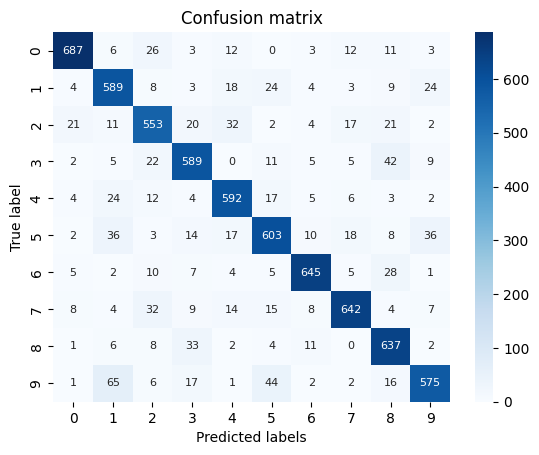

In [ ]:
evaluate_model(fcn, dataset='test')

From the confusion matrix we can clearly see that one of the caveats of this model is that it confuses 9 with 1 or 5.
Other than that the we don't catch any drastic anomalies, rest of the errors are more or less evenly distributed.
We can investigate the spectograms of the numbers that are close to each other to see if they are indeed similar.

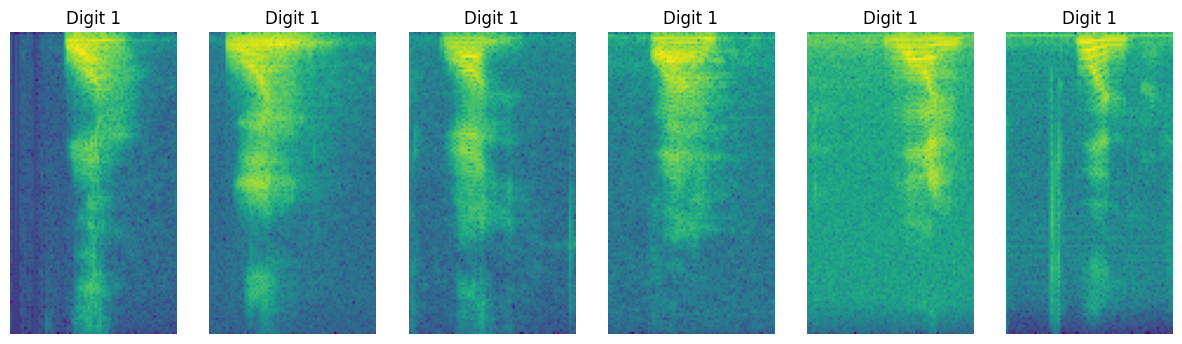

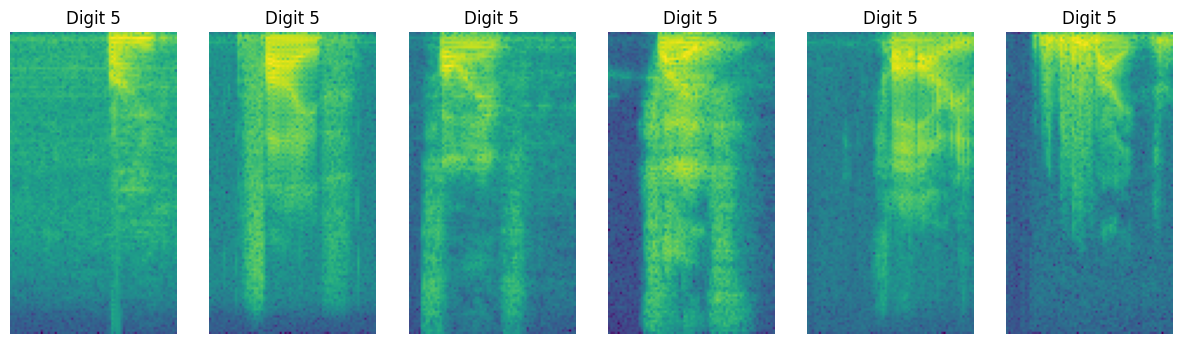

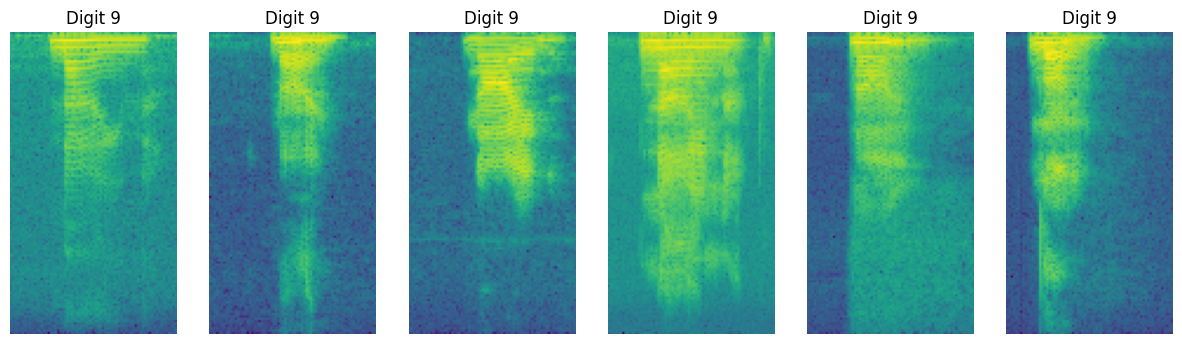

In [ ]:

def plot_spectograms(n = 5, digit = 1):

    _, axs = plt.subplots(1, n, figsize=(15, 5))

    # displaying few examples of the spectograms of the digit
    for i in range(n):
        # we are finding indices of spectograms of the digit
        idx = np.random.choice(np.where(y == digit)[0])
        axs[i].imshow(X[idx].numpy())
        axs[i].axis('off')
        axs[i].set_title(f"Digit {digit}")

    plt.show()


plot_spectograms(n=6,digit=1)
plot_spectograms(n=6,digit=5)
plot_spectograms(n=6,digit=9)

To be fair without domain knowledge, it is hard to tell if the 1s, 5s and 9s are similar or not. Of course it looks like there are some similar patterns, but the spectograms are too chaotic at least for us

In [ ]:
# we are using 3 convolution blocks with increasing number of features maps
# because we are using padding='same' the shape of the output of convolution will be the same as input
# we are using batch normalization and dropout to stabilize training
# we decided to use dropout only before the last linear layer as it was working nicely experimentally
class ConvNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.sequent = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64*16*8, 10)
        )

        self.sequent.apply(self.__init_weights)

    def forward(self, x):
        # in pytorch conv layers expect a shape (batch, channel, width, height)
        # therefore we need to view data in correct shape
        # view is better than reshape, because it actually doesn't reallocate memory od the data
        x = x.view(-1, 1, 129, 71)
        x = self.sequent(x)

        return x

    # because we are using RELU we still want to use kaiming init
    def __init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)


In [ ]:

# hyperparams are similar to the ones used for the FCN, but we train for much shorter time
# because this network is much 'stronger' and learns faster
cnn_hyperparams = {
    'n_epochs': 15,
    'lr': 0.001,
    'scheduler_patience': 3,
    'scheduler_factor': 0.5,
    'early_stop_patience': 5,
    'weight_decay': 0.1
}

In [ ]:
conv_net = ConvNet()

conv_net = conv_net.to(device)

# using same optimizer and scheduler as for the FCN
optimizer = torch.optim.AdamW(conv_net.parameters(), lr=cnn_hyperparams['lr'], weight_decay=cnn_hyperparams['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=cnn_hyperparams['scheduler_patience'], factor=cnn_hyperparams['scheduler_factor'])

In [ ]:
train(conv_net, optimizer,  scheduler,  cnn_hyperparams['n_epochs'], cnn_hyperparams['early_stop_patience'])

  7%|▋         | 1/15 [00:02<00:39,  2.80s/it]

Epoch 1 - Accuracy: 0.5505 - Loss: 1.8504 - Val Loss: 0.7238, Val accuracy: 0.7862


 13%|█▎        | 2/15 [00:05<00:36,  2.81s/it]

Epoch 2 - Accuracy: 0.7865 - Loss: 0.7802 - Val Loss: 0.4767, Val accuracy: 0.8637


 20%|██        | 3/15 [00:08<00:33,  2.80s/it]

Epoch 3 - Accuracy: 0.8559 - Loss: 0.4903 - Val Loss: 0.3179, Val accuracy: 0.8997


 27%|██▋       | 4/15 [00:11<00:30,  2.81s/it]

Epoch 4 - Accuracy: 0.8900 - Loss: 0.3567 - Val Loss: 0.2529, Val accuracy: 0.9219


 33%|███▎      | 5/15 [00:14<00:28,  2.83s/it]

Epoch 5 - Accuracy: 0.9100 - Loss: 0.2889 - Val Loss: 0.2179, Val accuracy: 0.9351


 40%|████      | 6/15 [00:16<00:25,  2.83s/it]

Epoch 6 - Accuracy: 0.9280 - Loss: 0.2283 - Val Loss: 0.2088, Val accuracy: 0.9374


 47%|████▋     | 7/15 [00:19<00:22,  2.83s/it]

Epoch 7 - Accuracy: 0.9358 - Loss: 0.1989 - Val Loss: 0.2129, Val accuracy: 0.9354


 53%|█████▎    | 8/15 [00:22<00:19,  2.84s/it]

Epoch 8 - Accuracy: 0.9435 - Loss: 0.1710 - Val Loss: 0.1615, Val accuracy: 0.9495


 60%|██████    | 9/15 [00:25<00:17,  2.84s/it]

Epoch 9 - Accuracy: 0.9502 - Loss: 0.1493 - Val Loss: 0.1526, Val accuracy: 0.9530


 67%|██████▋   | 10/15 [00:28<00:14,  2.85s/it]

Epoch 10 - Accuracy: 0.9527 - Loss: 0.1372 - Val Loss: 0.1668, Val accuracy: 0.9516


 73%|███████▎  | 11/15 [00:31<00:11,  2.87s/it]

Epoch 11 - Accuracy: 0.9589 - Loss: 0.1237 - Val Loss: 0.1631, Val accuracy: 0.9537


 80%|████████  | 12/15 [00:34<00:08,  2.86s/it]

Epoch 12 - Accuracy: 0.9600 - Loss: 0.1169 - Val Loss: 0.1915, Val accuracy: 0.9412


 87%|████████▋ | 13/15 [00:36<00:05,  2.86s/it]

Epoch 13 - Accuracy: 0.9621 - Loss: 0.1119 - Val Loss: 0.1715, Val accuracy: 0.9474


 93%|█████████▎| 14/15 [00:39<00:02,  2.85s/it]

Epoch 14 - Accuracy: 0.9740 - Loss: 0.0791 - Val Loss: 0.1345, Val accuracy: 0.9607


100%|██████████| 15/15 [00:42<00:00,  2.84s/it]

Epoch 15 - Accuracy: 0.9784 - Loss: 0.0666 - Val Loss: 0.1252, Val accuracy: 0.9633


Test accuracy: 0.9613


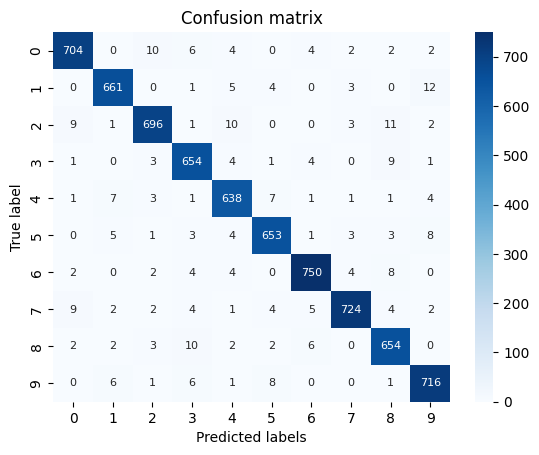

In [ ]:
evaluate_model(conv_net)

To sum up convolution network is much more powerful than fully connected network. However, it is more prone to overfitting as well as it is much more demanding in terms of computational power.